In [32]:
#import libraries for machine learning
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing
import matplotlib.pyplot as plt
from darts.models import RNNModel, NBEATSModel, BlockRNNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from darts.models import Prophet, ARIMA, StatsForecastAutoARIMA, VARIMA

plt.rcParams['figure.figsize'] = [20, 4]

#read in the csv file of the cleaned data
df = pd.read_csv('data/yahoo_stock.csv', delimiter=',')

#crate a time series object
ts_close = TimeSeries.from_dataframe(df, 'Date', 'Close')
ts_open = TimeSeries.from_dataframe(df, 'Date', 'Open')
ts_high = TimeSeries.from_dataframe(df, 'Date', 'High')
ts_low = TimeSeries.from_dataframe(df, 'Date', 'Low')
ts_volume = TimeSeries.from_dataframe(df, 'Date', 'Volume')

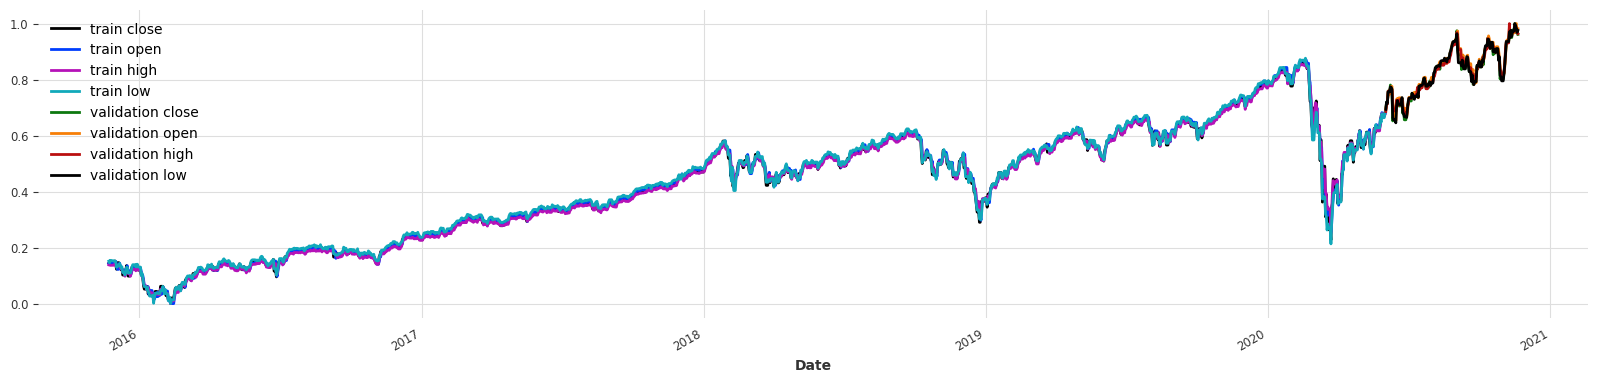

In [33]:
# preproccessing
scalar_close, scalar_open, scalar_high, scalar_low, scalar_volume = Scaler(), Scaler(), Scaler(), Scaler(), Scaler()
train_close_scaled = scalar_close.fit_transform(ts_close)
train_open_scaled = scalar_open.fit_transform(ts_open)
train_high_scaled = scalar_high.fit_transform(ts_high)
train_low_scaled = scalar_low.fit_transform(ts_low)
train_volume_scaled = scalar_volume.fit_transform(ts_volume)

# make validation set
train_close, val_close = train_close_scaled.split_after(pd.Timestamp('2020-06-01'))
train_open, val_open = train_open_scaled.split_after(pd.Timestamp('2020-06-01'))
train_high, val_high = train_high_scaled.split_after(pd.Timestamp('2020-06-01'))
train_low, val_low = train_low_scaled.split_after(pd.Timestamp('2020-06-01'))
train_volume, val_volume = train_volume_scaled.split_after(pd.Timestamp('2020-06-01'))


# plot scaled train and validation set
train_close.plot(label='train close')
train_open.plot(label='train open')
train_high.plot(label='train high')
train_low.plot(label='train low')

val_close.plot(label='validation close')
val_open.plot(label='validation open')
val_high.plot(label='validation high')
val_low.plot(label='validation low')

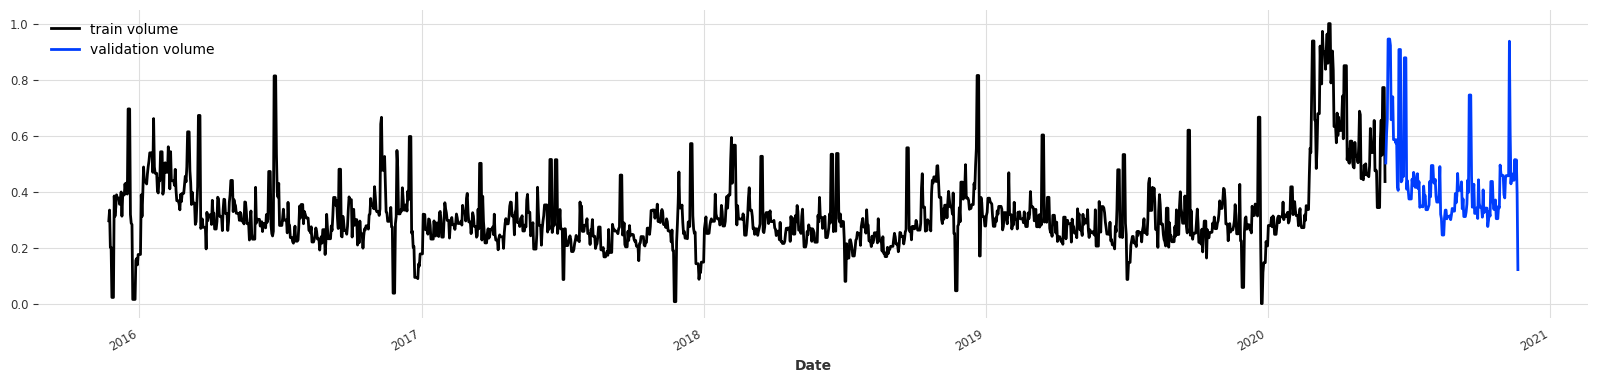

In [34]:
train_volume.plot(label='train volume')
val_volume.plot(label='validation volume')

In [24]:
# train LSTM model
model_lstm = BlockRNNModel(
    model='LSTM',
    input_chunk_length=100,
    output_chunk_length =25,
    n_epochs=50,
    random_state=0,
    pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]}
)
model_lstm.fit(series=[train_close, train_open, train_high, train_low])
# , train_volume

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.8 K 
4 | fc            | Sequential       | 650   
---------------------------------------------------
3.5 K     Trainable params
0         Non-traina

Epoch 49: 100%|██████████| 192/192 [00:02<00:00, 71.13it/s, train_loss=0.00145] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 192/192 [00:02<00:00, 71.11it/s, train_loss=0.00145]


In [25]:
# make the prediction using LSTM
future_lstm = model_lstm.predict(n=len(val_close), series=train_close)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.29it/s]


MAPE = 9.18%


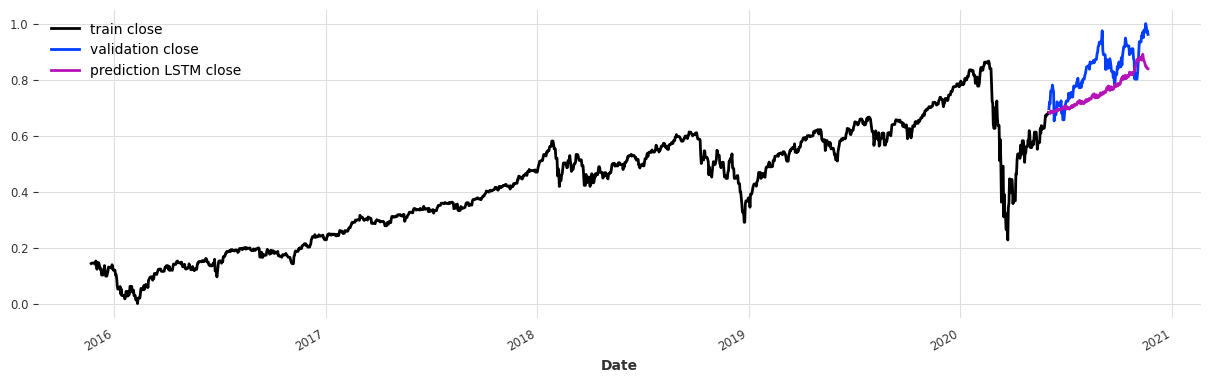

In [26]:
# plot the prediction 
train_close.plot(label='train close')
val_close.plot(label='validation close')
future_lstm.plot(label='prediction LSTM close')
plt.legend()
print("MAPE = {:.2f}%".format(mape(train_close_scaled, future_lstm)))

12:58:27 - cmdstanpy - INFO - Chain [1] start processing
12:58:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE = 19.58%


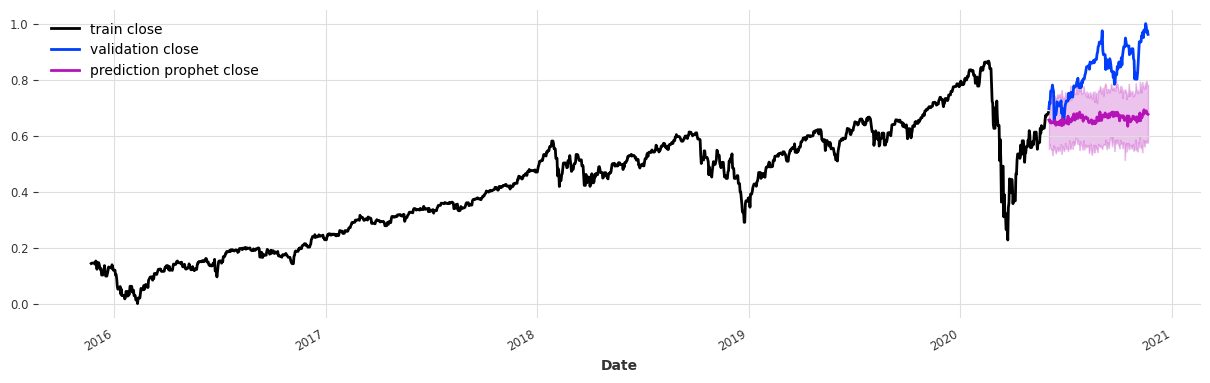

In [27]:
# make prophet model
model_prophet = Prophet()
model_prophet.fit(train_close)

# make the prediction using prophet
future_prophet = model_prophet.predict(n=len(val_close), num_samples=100)

# plot the prediction
train_close.plot(label='train close')
val_close.plot(label='validation close')
future_prophet.plot(label='prediction prophet close')
plt.legend()
print("MAPE = {:.2f}%".format(mape(train_close_scaled, future_prophet)))

MAPE = 18.50%


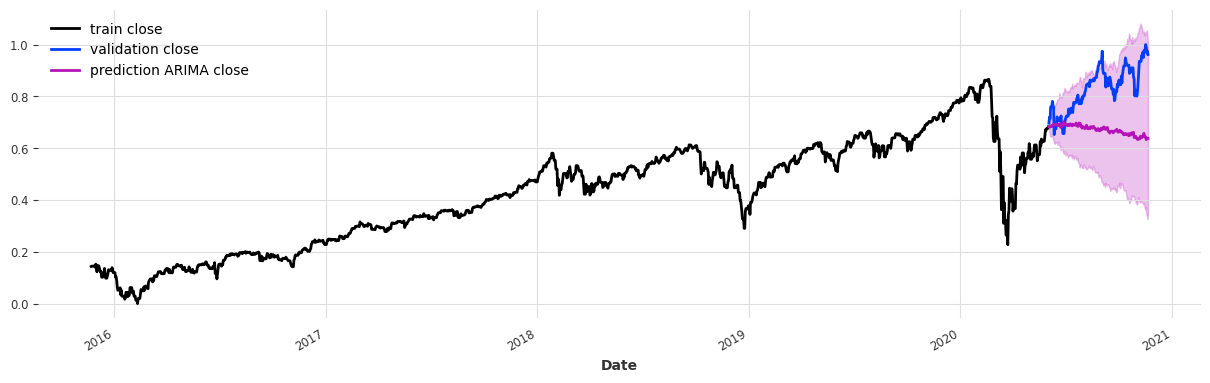

In [28]:
# make ARIMA model
model_arima = ARIMA()
model_arima.fit(train_close)

# make the prediction using ARIMA
future_arima = model_arima.predict(n=len(val_close), num_samples=100)

# plot the prediction
train_close.plot(label='train close')
val_close.plot(label='validation close')
future_arima.plot(label='prediction ARIMA close')
plt.legend()
print("MAPE = {:.2f}%".format(mape(train_close_scaled, future_arima)))

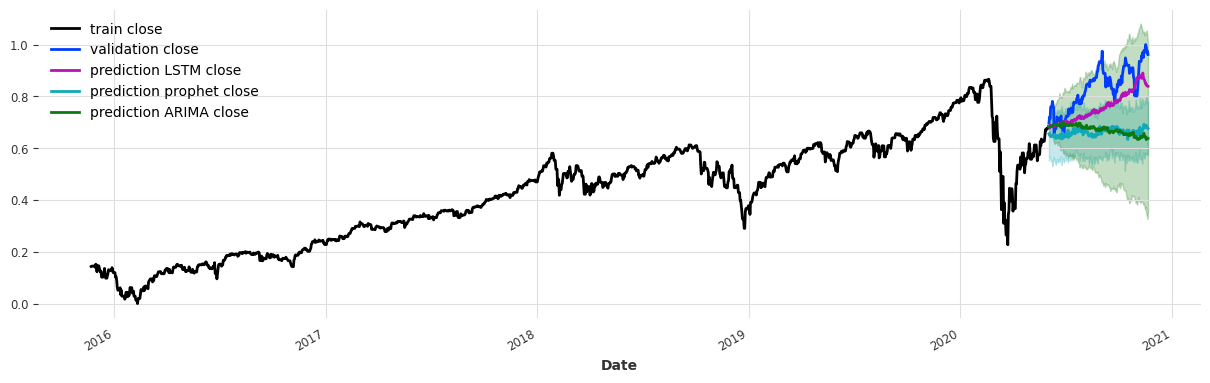

In [29]:
train_close.plot(label='train close')
val_close.plot(label='validation close')
future_lstm.plot(label='prediction LSTM close')
future_prophet.plot(label='prediction prophet close')
future_arima.plot(label='prediction ARIMA close')

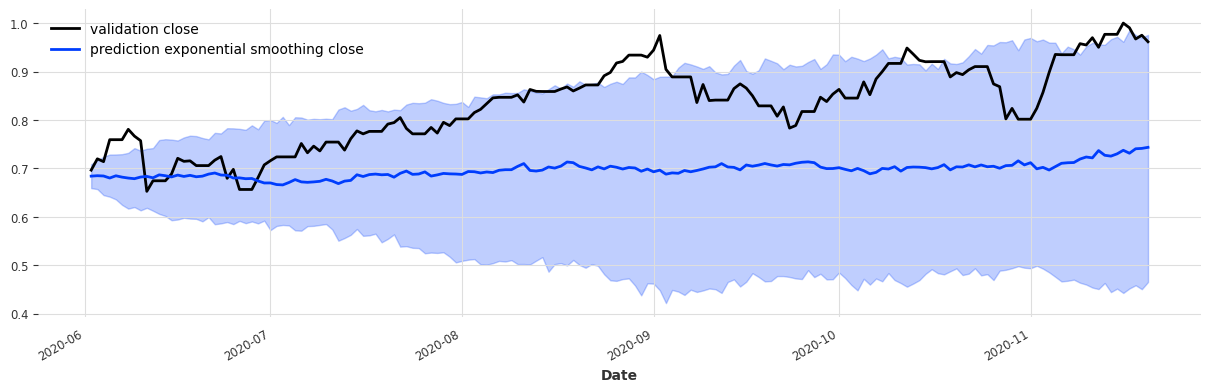

In [31]:
model_es = ExponentialSmoothing()
model_es.fit(train_close)

# make the prediction using exponential smoothing
future_es = model_es.predict(n=len(val_close), num_samples=100)
val_close.plot(label='validation close')
future_es.plot(label='prediction exponential smoothing close')